# VCModel

Machine information 

In [1]:
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## Demo data



For demonstration, we generate a random data set. We use the following distribution to generate response $Y$ of size $100 \times 3$:

$$Y \sim \text{Normal}(X\beta, \Sigma_1 \otimes V_1 + \cdots + \Sigma_{10}\otimes V_{10} + \Sigma_0 \otimes I_n)$$

where $\otimes$ indicates Kronecker product and each $\Sigma_i$ indicates variance component for $i$-th group, $i=0,1,\ldots, 10.$ We set  

$$\Sigma_i = \begin{cases} 1.5 \mathbf{I}_{100} & \text{ if } i=1,4,10 \\
                            \mathbf{I}_{100} & \text{ if } i=0 \\ 
                                \mathbf{0}& \text{ else. } \end{cases}$$

Define $\Omega = \text{Var}(Y) = \Sigma_1 \otimes V_1 + \cdots + \Sigma_{10} \otimes V_{10} + \Sigma_0\otimes I_n.$ The covariate matrix $X$ is generated using standard normal distribution. 



In [2]:
using LinearAlgebra, Random

## generate data from a d-variate response variance component model
Random.seed!(123)
n = 100          # no. observations
d = 3            # no. categories
m = 11           # no. variance components
p = 4            # no. covariates
X = randn(n, p)  # n-by-p covariate matrix 
β = ones(p, d)   # p-by-d mean component regression coefficient 

# a vector of d-by-d variance component parameters 
Σ = [zeros(d, d) for i in 1:m]
for i in [1, 4, 10]
  Σ[i] = 1.5 * Matrix{Float64}(I, d, d)
end
Σ[end] = Matrix{Float64}(I, d, d)

# a vector of covariance matrices 
V  = Array{Matrix{Float64}}(undef, m)
for i = 1:(m - 1)
  Vi = randn(n, 50)
  V[i] =  Vi * Vi'
  V[i] ./= norm(V[i])
end
V[end] = Matrix(I, n, n) ./ √n

# form overall nd-by-nd covariance matrix Ω
Ω = zeros(n*d, n*d)
for i = 1:m
    Ω .+= kron(Σ[i], V[i])
end
Ωchol = cholesky!(Symmetric(Ω))

# n-by-d responses
Y = X * β + reshape(Ωchol.L * randn(n*d), n, d);

True variance component parameter vector:

In [3]:
Σ

11-element Array{Array{Float64,2},1}:
 [1.5 0.0 0.0; 0.0 1.5 0.0; 0.0 0.0 1.5]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [1.5 0.0 0.0; 0.0 1.5 0.0; 0.0 0.0 1.5]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
 [1.5 0.0 0.0; 0.0 1.5 0.0; 0.0 0.0 1.5]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

## Goal

Suppose we wish to select $\Sigma_i, i=1,\ldots, 10$ that are associated with response $Y.$ This can be achieved by `VCSEL.jl` package. 

## Variance component selection

First load the package.

In [4]:
using VCSEL

┌ Info: Precompiling VCSEL [684d1ed6-5d62-11e9-0c0b-878d753c12b1]
└ @ Base loading.jl:1273


To perform selection, take 2 steps:

**Step 1 (Construct a model)**. Construct an instance of `VCModel`, which is the fundamental type for variance component model. It consists of fields 

* `Y`: $n$-by-$d$ responses. 
* `X`: $n$-by-$p$ covariate matrix (if exists).
* `V=(V[1],...,V[m],I)`: a vector of $n$-by-$n$ covariance matrices. The last covariance matrix must be positive definite and usually is a diagonal matrix. All `V[i]` should have frobenius norm 1. 
* `Σ=(Σ[1],...,Σ[m])`: a vector of initial estimates for $d$-by-$d$ variance component parameters. When $d=1$, `Σ` is a $m$-by-$1$ vector. If not supplied, it is set to be a vector of $d$-by-$d$ identity matrix by default. 

`VCModel` can be initialized by 

Let us construct a `VCModel` using `Y`, `X`, and `V`. Since we do not provide `Σ`, it is initialized to be a vector of identity matrices. 

In [5]:
vcm = VCModel(Y, X, V);

Since we did not set initial estimates of `Σ`, all elements are identity matrix. 

In [6]:
vcm.Σ

11-element Array{Array{Float64,2},1}:
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
 [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

**Step 2 (Optimize)**. Call optimization routine `vcselect!`. 

Required input argument for executing `vcselect!` is `VCModel`:
    
- `vcm`: `VCModel`.

Keyword Arguments are 

- `penfun`: penalty function. Default is `NoPenalty()`. Other options are `L1Penalty()` and `MCPPenalty()`.
- `λ`: tuning parameter. Default is 1.0.    
- `penwt`: penalty weights. Default is (1,...1,0).
- `standardize`: logical flag for covariance matrix standardization. Default is `false`.
    If true, `V[i]` is standardized by its Frobenius norm, and parameter estimates are 
    returned on the original scale.
- `maxiters`: maximum number of iterations. Default is 1000.
- `tol`: convergence tolerance. Default is `1e-5`.
- `verbose`: display switch. Default is false.
- `checktype`: check argument type switch. Default is true.

<a id='no-penalty'></a>
### No penalty 

First, we call `vcselect!` without specifying any penalty function. By default, it is fit with no penalty (i.e. $\lambda=0$).

In [7]:
vcm_nopen = deepcopy(vcm);
vcm_nopen, final_obj, niters, = vcselect!(vcm_nopen);
## equivalent to 
# vcselect!(vcm_nopen; penfun=NoPenalty());
# vcselect!(vcm_nopen; λ=0.0)

(VCModel{Float64}([1.860094835353257 2.055403434516128 2.84544587051332; 3.4359556067573895 2.8421454064488842 2.860512418851407; … ; -0.21488508947517132 -0.3336880873733919 0.3849750333444425; -2.7580470886596755 -3.400050457633945 -4.784333938275772], [1.1902678809862768 0.3762642112434747 0.34658945360812454 0.45809880324835406; 2.04817970778924 -0.4052717901213415 1.604313725337457 0.13912437753868148; … ; -0.16371133936712523 0.5752786905523419 -0.17655459673142 -0.045725895200926625; -0.9029858060964956 -0.16600120902535137 -1.2792370363858774 -1.3123821810547711], Array{Float64,2}[[0.092494023125743 0.0030042568249118926 … -0.00922398515864249 0.013285729616217755; 0.0030042568249118926 0.04025705934773749 … 0.003708804177337504 0.003823593679063355; … ; -0.00922398515864249 0.003708804177337504 … 0.039439277698925315 0.001178066910649526; 0.013285729616217755 0.003823593679063355 … 0.001178066910649526 0.06886830969476362], [0.06030328209283304 -0.001024446424453263 … 0.002416

The output of `vcselect!` contains 

* fitted model 

In [8]:
vcm_nopen;

Parameter estimates can be accessed as below:

In [9]:
# variance components
vcm_nopen.Σ 

11-element Array{Array{Float64,2},1}:
 [1.040392519682894 -0.9331650013274756 0.2698792614971673; -0.9331650013274755 1.8323672344949145 0.5027515826645772; 0.2698792614971673 0.5027515826645772 0.6285554861339957]                          
 [1.022164010367449 -0.40348987265201536 -0.32127925630485177; -0.40348987265201547 0.15944226901597186 0.12680764831035088; -0.3212792563048518 0.12680764831035088 0.10098342437882002]                 
 [0.04652475933325329 -0.15955065387098033 -0.09119883427438784; -0.15955065387098036 0.558496540875567 0.31799201475835637; -0.09119883427438785 0.31799201475835637 0.18118920760059967]                
 [0.3345667575960278 0.8714891952837133 -0.4085346910999654; 0.8714891952837132 2.283405973643672 -1.2403652975256347; -0.4085346910999654 -1.240365297525635 2.8288133260307773]                         
 [0.9234821871351467 -0.497494817604588 -0.02358520286780985; -0.4974948176045879 0.26800851998962266 0.012705734095699441; -0.02358520286780985 0.012

In [10]:
# mean regression coefficients 
vcm_nopen.β 

4×3 Array{Float64,2}:
 0.982624  0.993886  1.02794 
 0.978163  1.02323   0.971143
 0.925411  1.01458   0.898839
 0.868534  1.1076    1.02098 

In [11]:
# estimated nd-by-nd overall covariance matrix 
vcm_nopen.Ωest 

300×300 Array{Float64,2}:
  0.404642      0.0212995    -0.0439677    …  -0.000996711   0.00924459 
  0.0212995     0.297675     -0.0225235       -0.00142137   -0.00429534 
 -0.0439677    -0.0225235     0.355902         0.00217228    0.0148259  
  0.0141434     0.0137725    -0.00278179       0.00270504    0.00310854 
  0.00204811   -0.028574      0.00272162      -0.00533976   -0.000170068
  0.00778168   -0.0246549     0.0214009    …  -0.00351548    0.00481182 
  0.0214074     0.00720804   -0.0188076        0.00458159    0.00200145 
  0.0212846    -0.0168359     0.0235598       -0.00940152   -0.00161028 
  0.00027726   -0.00359327    0.0120295        0.0124774    -0.00456738 
  0.0333097     0.00505554   -0.00798919      -0.00368395    0.00712723 
  0.0337032     0.0174631     0.0144735    …  -0.00782776    0.00526143 
  0.00168991    0.0105267    -0.0387361        0.000699345  -0.0126745  
  0.0497327    -0.000448481   0.00476156      -0.00570844    0.00561756 
  ⋮                      

* final objective value

In [12]:
final_obj

224.08353228995801

* number of iterations to convergence

In [13]:
niters

276

### Selection at specific regularization parameter 

Now we specify penalty function `penfun=L1Penalty()` and regularization parameter value `λ=2.0`. 

In [14]:
vcm_L1 = deepcopy(vcm)
vcm_L1, obj_L1, niters_L1, = vcselect!(vcm_L1; penfun=L1Penalty(), λ=2.0);

In [15]:
vcm_L1.Σ

11-element Array{Array{Float64,2},1}:
 [0.723344411461242 -0.5371552915924754 0.2653186252185347; -0.5371552915924754 1.4582908604350255 0.5524782606904559; 0.2653186252185347 0.5524782606904559 0.6325518383029696]               
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                                                                                                       
 [0.057805236800426145 -0.17358417446955493 -0.10897979851692789; -0.17358417446955496 0.5212600756188006 0.32725770158442874; -0.1089797985169279 0.32725770158442874 0.20545912804073208]    
 [0.2913469143855766 0.7770359938857069 -0.4247453010516808; 0.7770359938857069 2.0730922239946166 -1.1687134116436118; -0.42474530105168085 -1.168713411643612 2.474665577830677]             
 [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                                                                                                       
 [

In [16]:
vcm_L1.β

4×3 Array{Float64,2}:
 1.03872   0.939329  0.975904
 0.993807  0.997929  0.969196
 0.951591  1.03716   0.887175
 0.910584  1.05514   1.07108 

In [17]:
obj_L1

246.1242780263884

In [18]:
niters_L1

135

### Obtain solution path 

`vcselectpath!` function to compute regularization path for a given penalty at a grid of the regularization parameter lambda values. `vcselectpath!` provides options for users to customize. Keyword arguments for the function are 

- `penfun`: penalty function (e.g. `NoPenalty()`, `L1Penalty()`, `MCPPenalty()`). Default is `NoPenalty()`.
- `penwt`: weights for penalty term. Default is (1,1,...1,0).
- `nλ`: number of `λ` values in the sequence. Default is 100. 
- `λpath`: user-provided sequence of `λ` values in ascending order. Typically the program computes its own `λ` sequence based on `nλ`, but supplying `λpath` overrides this.
- `maxiter`: maximum number of iteration for MM loop. Default is 1000.
- `standardize`: logical flag for covariance matrix standardization. Default is `false`. If true, `V[i]` is standardized by its Frobenius norm.
- `tol`: convergence tolerance. Default is `1e-6`.

When called without any penalty, `vcselectpath!` returns the same output as `vcselect!` with `penfun=NoPenalty()` ([compare the output](#no-penalty)). 

In [19]:
vcmpath_np = deepcopy(vcm)
Σ̂path_np, β̂path_np, λpath_np, objpath_np, niterspath_np = vcselectpath!(vcmpath_np)

(Array{Float64,2}[[1.040392519682894 -0.9331650013274756 0.2698792614971673; -0.9331650013274755 1.8323672344949145 0.5027515826645772; 0.2698792614971673 0.5027515826645772 0.6285554861339957], [1.022164010367449 -0.40348987265201536 -0.32127925630485177; -0.40348987265201547 0.15944226901597186 0.12680764831035088; -0.3212792563048518 0.12680764831035088 0.10098342437882002], [0.04652475933325329 -0.15955065387098033 -0.09119883427438784; -0.15955065387098036 0.558496540875567 0.31799201475835637; -0.09119883427438785 0.31799201475835637 0.18118920760059967], [0.3345667575960278 0.8714891952837133 -0.4085346910999654; 0.8714891952837132 2.283405973643672 -1.2403652975256347; -0.4085346910999654 -1.240365297525635 2.8288133260307773], [0.9234821871351467 -0.497494817604588 -0.02358520286780985; -0.4974948176045879 0.26800851998962266 0.012705734095699441; -0.02358520286780985 0.012705734095699441 0.0006023662559145914], [0.5212700918589973 -0.3487119661493774 0.2065217351077744; -0.34

In [20]:
Σ̂path_np

11-element Array{Array{Float64,2},1}:
 [1.040392519682894 -0.9331650013274756 0.2698792614971673; -0.9331650013274755 1.8323672344949145 0.5027515826645772; 0.2698792614971673 0.5027515826645772 0.6285554861339957]                          
 [1.022164010367449 -0.40348987265201536 -0.32127925630485177; -0.40348987265201547 0.15944226901597186 0.12680764831035088; -0.3212792563048518 0.12680764831035088 0.10098342437882002]                 
 [0.04652475933325329 -0.15955065387098033 -0.09119883427438784; -0.15955065387098036 0.558496540875567 0.31799201475835637; -0.09119883427438785 0.31799201475835637 0.18118920760059967]                
 [0.3345667575960278 0.8714891952837133 -0.4085346910999654; 0.8714891952837132 2.283405973643672 -1.2403652975256347; -0.4085346910999654 -1.240365297525635 2.8288133260307773]                         
 [0.9234821871351467 -0.497494817604588 -0.02358520286780985; -0.4974948176045879 0.26800851998962266 0.012705734095699441; -0.02358520286780985 0.012

In [21]:
β̂path_np

4×3 Array{Float64,2}:
 0.982624  0.993886  1.02794 
 0.978163  1.02323   0.971143
 0.925411  1.01458   0.898839
 0.868534  1.1076    1.02098 

Now let us call `vcselectpath!` with `penfun=L1Penalty()`. Since we do not provide `nλ` or `λpath`, a grid of 100 $λ$ values is generated internally. 

In [22]:
vcm_path = deepcopy(vcm)
Σ̂path, β̂path, λpath, objpath, niterspath = vcselectpath!(vcm_path; 
    penfun=L1Penalty());

Output of `vcselectpath!` include

* variance component parameters path: $(i,j)$-th element corresponds to $i$-th variance component matrix at `λpath[j]`, $i=1,\ldots, 10, \; j=1,\ldots, 100$. The last row is for the residual variance component $\Sigma_0.$ 

In [23]:
Σ̂path

11×100 Array{Array{Float64,2},2}:
 [0.964484 -0.878534 0.291246; -0.878534 1.87357 0.409527; 0.291246 0.409527 0.512356]                       …  [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                           
 [0.88697 -0.168999 -0.324029; -0.168999 0.0419948 0.0591281; -0.324029 0.0591281 0.11907]                      [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                           
 [0.0319492 -0.13754 -0.0880763; -0.13754 0.62292 0.396603; -0.0880763 0.396603 0.252673]                       [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]                                                                           
 [0.428464 0.897827 -0.297535; 0.897827 2.06265 -1.2974; -0.297535 -1.2974 2.71189]                             [2.46063e-16 1.17441e-15 -2.61995e-15; 1.17441e-15 5.6052e-15 -1.25045e-14; -2.61995e-15 -1.25045e-14 2.78959e-14]
 [0.856367 -0.562249 -0.033135; -0.562249 0.369145 0.02175

Let's take a trace of each matrix:

In [24]:
tr.(Σ̂path)

11×100 Array{Float64,2}:
 3.35041     3.33039      3.30816   …   0.0        0.0        0.0        
 1.04804     1.03808      1.02683       0.0        0.0        0.0        
 0.907542    0.898144     0.885295      0.0        0.0        0.0        
 5.203       5.17787      5.15092       0.825608   0.771447   3.37472e-14
 1.22679     1.21322      1.19014       0.0        0.0        0.0        
 1.67159     1.66089      1.64623   …   0.0        0.0        0.0        
 0.585341    0.580511     0.57497       0.0        0.0        0.0        
 7.21984e-6  5.01809e-11  0.0           0.0        0.0        0.0        
 2.03054     2.01968      2.00984       0.0        0.0        0.0        
 3.78405     3.7625       3.7398        0.0        0.0        0.0        
 0.168677    0.172197     0.185863  …  10.6502    10.7018    11.8818     

* mean regression coefficient path: $j$-th element in `β̂path` corresponds to $p$-by-$d$ coefficients at `λpath[j]`.

In [25]:
β̂path

100-element Array{Array{Float64,2},1}:
 [0.970056800145968 0.9851818306585971 1.0277546485318616; 0.9908578041843322 1.0061729340146155 0.9659683457092927; 0.9303366182743511 1.012214164262387 0.8975771117837166; 0.8847476898983968 1.099588226998865 1.0228019849814547]   
 [0.9700547931669993 0.9851779231715498 1.0277510875539613; 0.9908802640938679 1.0061577572436342 0.9658958974324092; 0.9303930452096053 1.0121340331688236 0.8975326423167677; 0.8849021700106763 1.0994636400779647 1.0228591571458627]
 [0.9700216041732665 0.9852773221641971 1.0276975105242259; 0.9908827323213368 1.0062150636206364 0.9657504293012046; 0.930394337310919 1.0120439159067223 0.8974129497586784; 0.8853887862472509 1.0992277983182828 1.022970924868811]  
 [0.9700017757626326 0.9854217116375406 1.0276096831691022; 0.9909047780954122 1.0063277583222079 0.9655654879681046; 0.9303376378895787 1.0120129019383362 0.8972854011254249; 0.8860082791378023 1.0989637058316624 1.0230784657302048]
 [0.9700026714875383 0.98

* grid of $\lambda$ values used 

In [26]:
λpath 

0.0:0.1269064028253433:12.563733879708987

* final objective values at each $\lambda$

In [27]:
objpath

100-element Array{Float64,1}:
 223.40005049467874
 224.99712897026978
 226.58538820287092
 228.1656708528255 
 229.73827732323977
 231.30381424161686
 232.86211979463877
 234.4135219704821 
 235.9575418880073 
 237.49428062672098
 239.02376573588506
 240.5459426422662 
 242.06017758327576
   ⋮               
 276.0384210677173 
 276.1674326241919 
 276.2950955955481 
 276.42130502307646
 276.5459455857025 
 276.66861774127557
 276.78923597163015
 276.9076205222513 
 277.023466500422  
 277.1357503071525 
 277.24304973634975
 273.0763363663427 

* number of iterations at each $\lambda$

In [28]:
niterspath

100-element Array{Int64,1}:
 215
  10
  20
  22
  22
  20
  19
  17
  17
  17
  17
  17
  19
   ⋮
   6
   7
   7
   7
   7
   8
   9
  10
  11
  14
  19
 137

To get the order in which variance components entered the solution path, we use `rankvarcomps` function:

In [29]:
posvarcomps, zerovarcomps = rankvarcomps(Σ̂path)

([4, 10, 1, 9, 2, 7, 6, 5, 3], [8, 11])

Note that output includes two vectors. The first vector `posvarcomps` displays indices of variance components in the order they entered the solution path; the second vector `zerovarcomps` shows indices of those that are zero (except when $\lambda=0)$ and residual variance component, in no particular order. 

In [30]:
posvarcomps

9-element Array{Int64,1}:
  4
 10
  1
  9
  2
  7
  6
  5
  3

In [31]:
zerovarcomps

2-element Array{Int64,1}:
  8
 11

## Visualize/summarize

We can visualize `Σ̂path` via `plotsolpath` function. 
When variance component parameter is a matrix, `plotsolpath` calculates its trace and plots norms at each $\lambda$. 



Required arguments of `plotsolfunction` are

* `Σ̂path`: solution path generated from `vcselectpath!`
* `λpath`: grid of $\lambda$ values used for `Σ̂path`.

Keyword arguemnts are 

- `title`: title of the figure. Default is "Solution Path".
- `xlab`: x-axis label. Default is "$\lambda$".
- `ylab`: y-axis label. Default is "$\sigma^2$" or "trace$(\Sigma)$".
- `xmin`: lower limit for x-axis. Default is minimum of `λpath`.
- `xmax`: upper limit for x-axis. Default is maximum of `λpath`.
- `linewidth`: line width. Default is 1.0.
- `nranks`: no. of ranks to displayed on legend. Default is total number of variance components.
- `legend`: logical flag for including legend. Default is true.
- `legendout`: logical flag for moving the legend outside the plot. Default is true. 
- `legendtitle`: legend title. Default is "Ranking". 
- `resvarcomp`: logical flag for indicating residual variance component in `σ2path`. Default is true. 

Resulting plot includes a legend, which displays the order variance components enter the solution path. Here we use `legendout=false` option to place the legend within the figure. 

We exclude the last variance component (residual variance component) from the solution path:

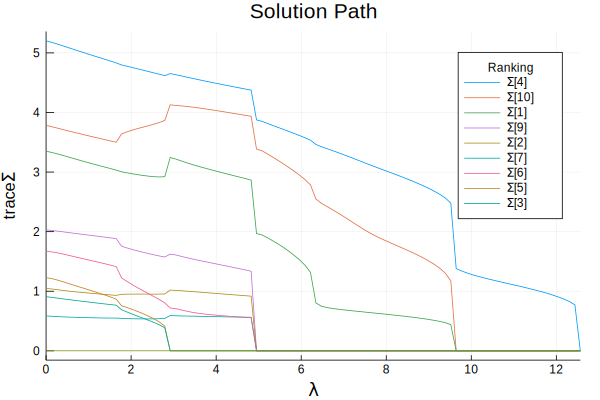

In [32]:
plotsolpath(Σ̂path[1:end-1, :], λpath; legendout=false, resvarcomp=false, 
    ylab="trace\\Sigma")

Note the ranking in the legend matches that from `rankvarcomps` as well:

In [33]:
ranking, zerovarcomps = rankvarcomps(Σ̂path)

([4, 10, 1, 9, 2, 7, 6, 5, 3], [8, 11])